In [1]:
import numpy as np
import pandas as pd

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import IsolationForest
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import sklearn.preprocessing as pre
from transforming import WithSelected, DFPowerTransform, Apply, Calc, Select, boruta

from sklearn.metrics import f1_score, roc_auc_score

__loading__

In [2]:
source = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

X_source = source.drop(columns=['id', 'target'])
y = source.target

__preprocessing & FE__

In [10]:
original = ['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc']
pipe = make_pipeline(
    Calc('calc * urea', to='ion_prod'),
    Calc('calc / urea', to='ion_rate'),
    Calc('osmo / gravity', to='osmo_gravity_rate'),
    Calc('calc / ph', to='calc_ph_rate'),
    
    WithSelected(None, 'pow')(
        DFPowerTransform()
    ),
    WithSelected(['calc', 'ph', 'gravity'], suffix='bins')(
        pre.KBinsDiscretizer(7, encode='onehot', strategy='kmeans')
    ),

    Apply(
        # estimator=LinearDiscriminantAnalysis(),
        # locpipe=pre.Normalizer(),
        estimator=LinearDiscriminantAnalysis(solver='lsqr'),
        locpipe=pre.StandardScaler(),
        # on=lambda columns: [col for col in columns if 'pow' in col],
        to='lda',
        as_proba=True
    ),
    Apply(
        estimator=KNeighborsClassifier(7, leaf_size=30, n_jobs=-1),
        to='neighbours',
        as_proba=True
    ),
    Apply(
        estimator=IsolationForest(n_estimators=10, max_samples='auto', warm_start=True, bootstrap=True, n_jobs=-1, random_state=17),
        locpipe=pre.Normalizer(),
        to='isolation'
    ),

    Calc('neighbours / calc', to='ngb_calc_rate'),
    Calc('lda / calc', to='lda_calc_rate'),
    Calc('neighbours / ph', to='ngb_ph_rate'),
    Calc('lda / ph', to='lda_ph_rate'),
    Calc('neighbours / gravity', to='ngb_gravity_rate'),
    Calc('lda / gravity', to='lda_gravity_rate'),

    Calc('neighbours / lda', to='ngb_lda_rate'),

    # Drop(original),
    # Drop([col for col in X.columns if 'calc' in col])\
    # Select(['lda_gravity_rate', 'lda', 'lda_ph_rate', 'ngb_calc_rate', 'neighbours', 
    #         'ngb_gravity_rate', 'ngb_ph_rate', 'ngb_lda_rate', 'lda_calc_rate', 'ion_rate_pow', 
    #         'calc_pow', 'ph_pow', 'ion_rate', 'ion_prod_pow', 'gravity', 
    #         'cond_pow', 'cond', 'calc', 'calc_ph_rate', 'ph_bins_2'])
)

In [4]:
types = {
    'osmo_pow_bins': int,
    'cond_bins': int,
    'cond_pow_bins': int,
    'urea_bins': int,
    'urea_pow_bins': int,
    'calc_bins': int,
    'calc_pow_bins': int,
}

In [11]:
# X = source.drop(columns=['id', 'target'])     # basic dataframe
# X = pipe.fit_transform(X_source, y).astype(types)
X = pipe.fit_transform(X_source, y)
X.head()

,gravity,cond,calc,ion_rate,calc_ph_rate,ph_pow,cond_pow,calc_pow,ion_prod_pow,ion_rate_pow,ph_bins_2,lda,neighbours,ngb_calc_rate,lda_calc_rate,ngb_ph_rate,lda_ph_rate,ngb_gravity_rate,lda_gravity_rate,ngb_lda_rate
0,1.013,14.8,1.45,0.011694,0.234249,0.561764,-0.896527,-0.899271,-1.083471,-0.207955,0.0,0.112236,0.285714,0.197044,0.077404,0.046157,0.018132,0.282048,0.110795,2.545660
1,1.025,23.6,4.18,0.010609,0.774074,-0.925220,0.271176,0.361559,0.614630,-0.356519,0.0,0.699795,0.714286,0.170882,0.167415,0.132275,0.129592,0.696864,0.682726,1.020708
2,1.009,24.5,9.04,0.056855,1.474715,0.472669,0.393761,1.379121,0.491834,2.187246,0.0,0.910057,0.714286,0.079014,0.100670,0.116523,0.148460,0.707914,0.901940,0.784880
3,1.021,20.8,6.63,0.016658,1.350305,-2.325350,-0.106754,0.967557,1.061361,0.377682,0.0,0.865935,0.857143,0.129282,0.130609,0.174571,0.176361,0.839513,0.848124,0.989847
4,1.021,17.8,2.21,0.005740,0.399638,-0.626023,-0.505359,-0.430205,0.043151,-1.133546,0.0,0.358507,0.285714,0.129282,0.162220,0.051666,0.064829,0.279838,0.351133,0.796957


__fit & validate__

In [14]:
def checkup(estimator, X, folds=7):
    metrics = []
    kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=19)
    for f, (train, valid) in enumerate(kf.split(X, y)):
        estimator.fit(X.loc[train], y[train])
        
        pt = estimator.predict_proba(X.loc[train]).T[1]
        pv = estimator.predict_proba(X.loc[valid]).T[1]

        auc_train = roc_auc_score(y[train], pt)
        auc_valid = roc_auc_score(y[valid], pv)
        f1_train = f1_score(y[train], pt > 0.5)
        f1_valid = f1_score(y[valid], pv > 0.5)
        metrics.append((auc_train, f1_train, auc_valid, f1_valid))
        print(f'Fold: {f}; TRAIN ROC AUC={auc_train:.5f}; TRAIN f1={f1_train:.5f} | VALID ROC AUC={auc_valid:.5f}; VALID f1={f1_valid:.5f}')
    means = np.mean(metrics, axis=0)
    print(f'MEAN: TRAIN ROC AUC={means[0]:.5f}; TRAIN f1={means[1]:.5f} | VALID ROC AUC={means[2]:.5f}; VALID f1={means[3]:.5f}')
    return estimator

In [15]:
checkup(KNeighborsClassifier(3, leaf_size=17, n_jobs=-1), X, folds=7);

Fold: 0; TRAIN ROC AUC=0.94001; TRAIN f1=0.84639 | VALID ROC AUC=0.61616; VALID f1=0.54545
Fold: 1; TRAIN ROC AUC=0.93936; TRAIN f1=0.85531 | VALID ROC AUC=0.82110; VALID f1=0.69388
Fold: 2; TRAIN ROC AUC=0.93292; TRAIN f1=0.83871 | VALID ROC AUC=0.81702; VALID f1=0.66667
Fold: 3; TRAIN ROC AUC=0.92961; TRAIN f1=0.83974 | VALID ROC AUC=0.82110; VALID f1=0.76923
Fold: 4; TRAIN ROC AUC=0.93067; TRAIN f1=0.83544 | VALID ROC AUC=0.79720; VALID f1=0.71698
Fold: 5; TRAIN ROC AUC=0.92048; TRAIN f1=0.81789 | VALID ROC AUC=0.84557; VALID f1=0.74194
Fold: 6; TRAIN ROC AUC=0.93935; TRAIN f1=0.84967 | VALID ROC AUC=0.82697; VALID f1=0.76923
MEAN: TRAIN ROC AUC=0.93320; TRAIN f1=0.84045 | VALID ROC AUC=0.79216; VALID f1=0.70048


### LGBM

Fold: 0; TRAIN ROC AUC=0.94153; TRAIN f1=0.82958 | VALID ROC AUC=0.82267; VALID f1=0.68000
Fold: 1; TRAIN ROC AUC=0.93468; TRAIN f1=0.82609 | VALID ROC AUC=0.87879; VALID f1=0.76923
Fold: 2; TRAIN ROC AUC=0.94368; TRAIN f1=0.84592 | VALID ROC AUC=0.80303; VALID f1=0.72000
Fold: 3; TRAIN ROC AUC=0.93815; TRAIN f1=0.81212 | VALID ROC AUC=0.84732; VALID f1=0.75000
Fold: 4; TRAIN ROC AUC=0.93512; TRAIN f1=0.81957 | VALID ROC AUC=0.84149; VALID f1=0.76364
Fold: 5; TRAIN ROC AUC=0.93536; TRAIN f1=0.82609 | VALID ROC AUC=0.91375; VALID f1=0.84211
Fold: 6; TRAIN ROC AUC=0.94094; TRAIN f1=0.83537 | VALID ROC AUC=0.86343; VALID f1=0.71698
MEAN: TRAIN ROC AUC=0.93849; TRAIN f1=0.82782 | VALID ROC AUC=0.85293; VALID f1=0.74885


100%|██████████| 25/25 [00:01<00:00, 12.55it/s]


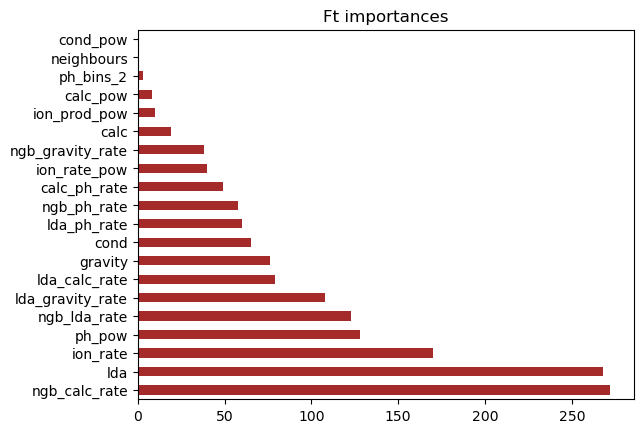

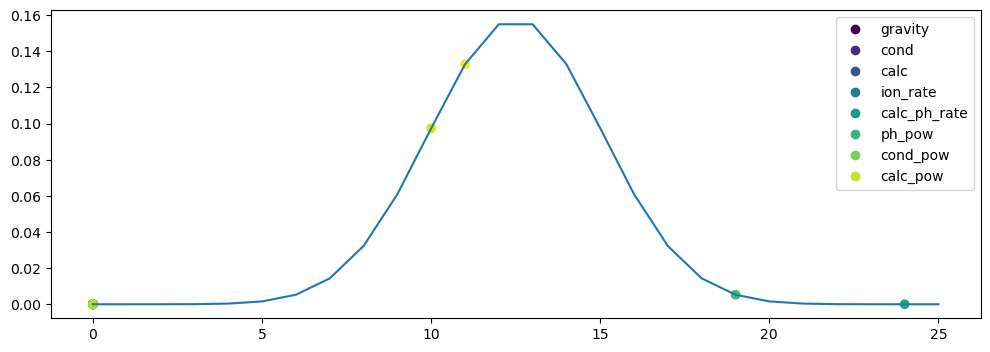

In [16]:
# FIT LGBM
est = checkup(LGBMClassifier(n_estimators=250, learning_rate=0.01, max_depth=3, n_jobs=-1, random_state=11), X, folds=7);
feat_importances = pd.Series(est.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh', title='Ft importances', color='brown');
imp = boruta(X, y, iterations=25, seed=17, plot=True, estimator=est)

### CatBoost

Fold: 0; TRAIN ROC AUC=0.91409; TRAIN f1=0.78370 | VALID ROC AUC=0.84736; VALID f1=0.73077
Fold: 1; TRAIN ROC AUC=0.90840; TRAIN f1=0.77259 | VALID ROC AUC=0.87879; VALID f1=0.76923
Fold: 2; TRAIN ROC AUC=0.91599; TRAIN f1=0.81081 | VALID ROC AUC=0.82984; VALID f1=0.72000
Fold: 3; TRAIN ROC AUC=0.91698; TRAIN f1=0.80982 | VALID ROC AUC=0.86364; VALID f1=0.72727
Fold: 4; TRAIN ROC AUC=0.91461; TRAIN f1=0.80243 | VALID ROC AUC=0.86713; VALID f1=0.74074
Fold: 5; TRAIN ROC AUC=0.90522; TRAIN f1=0.78769 | VALID ROC AUC=0.92075; VALID f1=0.84746
Fold: 6; TRAIN ROC AUC=0.91594; TRAIN f1=0.80606 | VALID ROC AUC=0.87731; VALID f1=0.70588
MEAN: TRAIN ROC AUC=0.91303; TRAIN f1=0.79616 | VALID ROC AUC=0.86926; VALID f1=0.74876


100%|██████████| 25/25 [00:05<00:00,  4.66it/s]


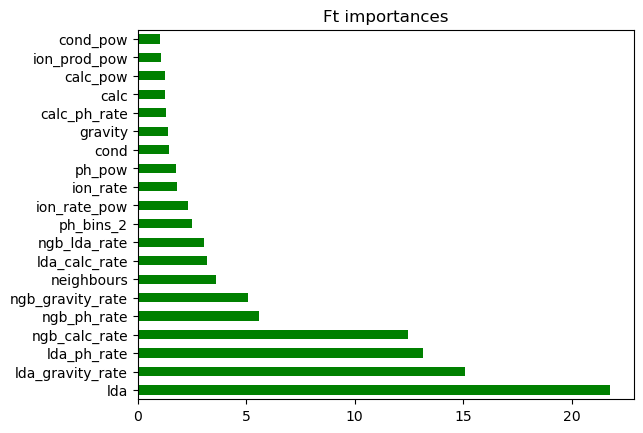

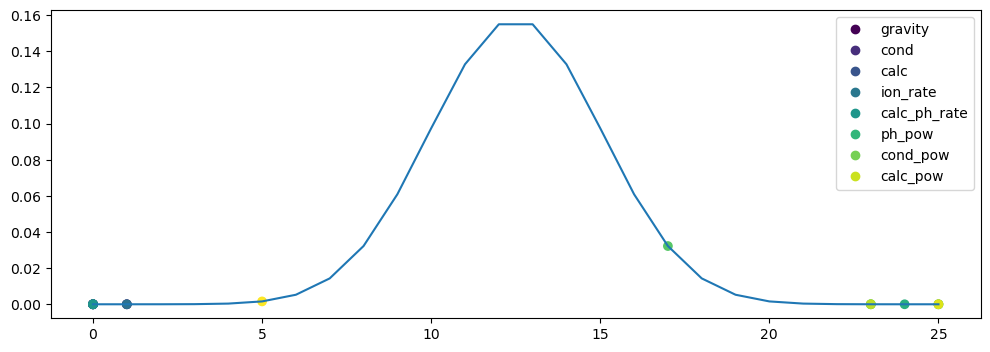

In [17]:
# FIT CatBoost
# cat_features = [col for col in X.columns if 'bins' in col]
cat_features = [col for col in X.columns if X[col].dtype == 'category']
est = checkup(CatBoostClassifier(iterations=250, learning_rate=0.01, depth=3, cat_features=cat_features, random_state=11, verbose=False, allow_writing_files=False), X, folds=7);
feat_importances = pd.Series(est.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh', title='Ft importances', color='green');
imp = boruta(X, y, iterations=25, seed=17, plot=True, estimator=est)

### XGBoost

Fold: 0; TRAIN ROC AUC=0.95089; TRAIN f1=0.85625 | VALID ROC AUC=0.81706; VALID f1=0.66667
Fold: 1; TRAIN ROC AUC=0.94010; TRAIN f1=0.83333 | VALID ROC AUC=0.88170; VALID f1=0.79245
Fold: 2; TRAIN ROC AUC=0.95611; TRAIN f1=0.85542 | VALID ROC AUC=0.80653; VALID f1=0.68000
Fold: 3; TRAIN ROC AUC=0.95113; TRAIN f1=0.85196 | VALID ROC AUC=0.84266; VALID f1=0.73684
Fold: 4; TRAIN ROC AUC=0.94468; TRAIN f1=0.83077 | VALID ROC AUC=0.84033; VALID f1=0.71698
Fold: 5; TRAIN ROC AUC=0.93979; TRAIN f1=0.83077 | VALID ROC AUC=0.92075; VALID f1=0.86207
Fold: 6; TRAIN ROC AUC=0.94871; TRAIN f1=0.82317 | VALID ROC AUC=0.86400; VALID f1=0.70588
MEAN: TRAIN ROC AUC=0.94734; TRAIN f1=0.84024 | VALID ROC AUC=0.85329; VALID f1=0.73727


100%|██████████| 25/25 [00:07<00:00,  3.23it/s]


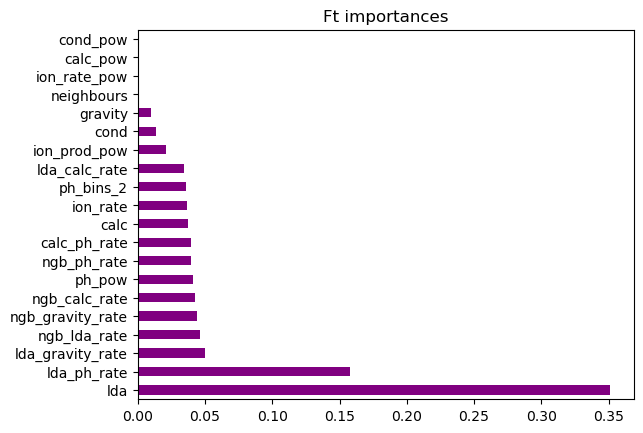

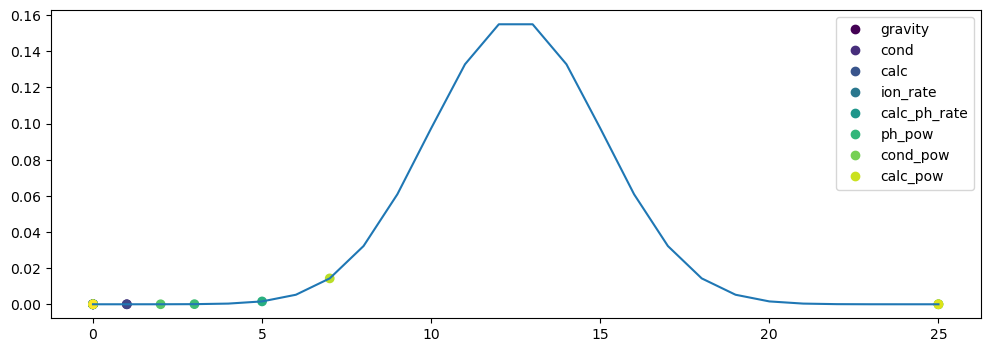

In [20]:
# FIT XGBoost
est = checkup(XGBClassifier(n_estimators=250, learning_rate=0.01, max_depth=3, random_state=23), X, folds=7);
feat_importances = pd.Series(est.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh', title='Ft importances', color='purple');
imp = boruta(X, y, iterations=25, seed=17, plot=True, estimator=est)

### features selection

100%|██████████| 50/50 [00:13<00:00,  3.74it/s]


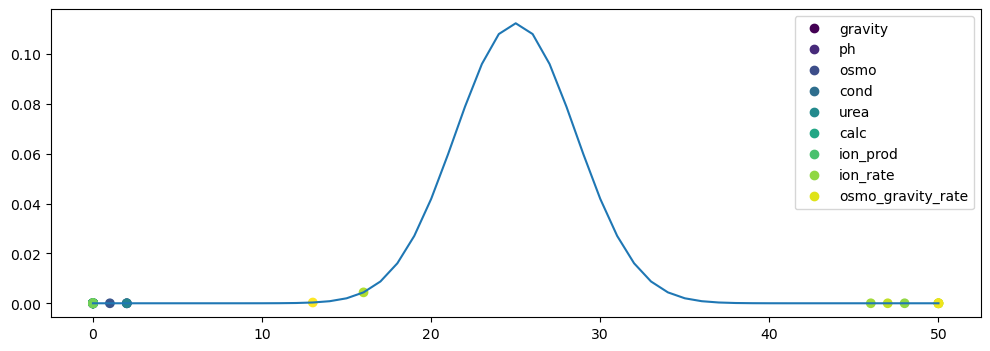

,feature,sf,keep
40,ngb_gravity_rate,0.000000e+00,True
39,lda_ph_rate,0.000000e+00,True
34,lda,0.000000e+00,True
41,lda_gravity_rate,0.000000e+00,True
35,neighbours,4.529710e-14,True
38,ngb_ph_rate,1.133316e-12,True
36,ngb_calc_rate,1.854161e-11,True
37,lda_calc_rate,9.923267e-01,False
42,ngb_lda_rate,9.995319e-01,False
5,calc,1.000000e+00,False


In [5]:
boruta(X, y, iterations=50, seed=17, plot=True,
    estimator=CatBoostClassifier(iterations=250, learning_rate=0.01, depth=3, random_state=11, verbose=False, allow_writing_files=False)
)

In [ ]:
#